-289
10
Distance:-  289.1729586251107
((166, 213), (455, 203))
((166, 213), (455, 203))


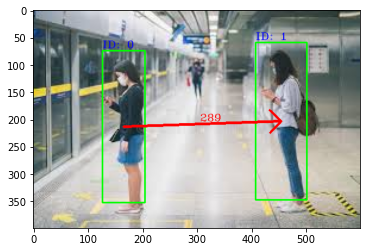

In [68]:
import cv2
import datetime
import imutils
import numpy as np
from centroidtracker import CentroidTracker
from itertools import combinations
import math
import matplotlib.pyplot as plt

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=40, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
    #cap = cv2.VideoCapture('')

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    
    #ret, frame = cap.read()
    frame = cv2.imread('img/test.jpg')
    frame =  cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = imutils.resize(frame, width=600)
    total_frames = total_frames + 1

    (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

    detector.setInput(blob)
    person_detections = detector.forward()
    rects = []
    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])

            if CLASSES[idx] != "person":
                continue

            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            rects.append(person_box)

    boundingboxes = np.array(rects)
    boundingboxes = boundingboxes.astype(int)
    rects = non_max_suppression_fast(boundingboxes, 0.3)
    centroid_dict = dict()
    objects = tracker.update(rects)
    for (objectId, bbox) in objects.items():
        x1, y1, x2, y2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        cX = int((x1 + x2) / 2.0)
        cY = int((y1 + y2) / 2.0)


        centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

        text = "ID: {}".format(objectId)
        cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    
    for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
        dx, dy = p1[0] - p2[0], p1[1] - p2[1]
        #shape = [(p1[0], p1[1]), (p2[0], p2[1])]
        #frame.line(shape, fill ="red", width = 0)
        distance = math.sqrt(dx * dx + dy * dy)
        print(dx)
        print(dy)
        print("Distance:- ",distance)
        
    for id, box in centroid_dict.items():
        
        cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2)
        shape = ((p1[0], p1[1]), (p2[0], p2[1]))
        print(shape)
        frame = cv2.arrowedLine(frame, (p1[0], p1[1]),(p2[0], p2[1]), (255,0,0), 3)
        text = str(round(distance))
        cv2.putText(frame, text, (round((p1[0]+p2[0]-10)/2), round((p1[1]+p2[1])/2-5)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)
        #frame.line(shape, fill ="red", width = 0)
        

    fps_end_time = datetime.datetime.now()
    time_diff = fps_end_time - fps_start_time
    if time_diff.seconds == 0:
        fps = 0.0
    else:
        fps = (total_frames / time_diff.seconds)

    fps_text = "FPS: {:.2f}".format(fps)

    #cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    cv2.imshow("Application", frame)
    plt.imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


main()


((167, 207), (451, 197))
-284
10
Distance:-  284.17600180170035


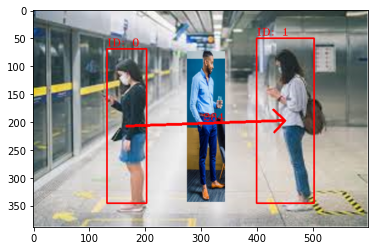

In [69]:
import cv2
import datetime
import imutils
import numpy as np
from centroidtracker import CentroidTracker
from itertools import combinations
import math
import matplotlib.pyplot as plt

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=40, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
    #cap = cv2.VideoCapture('')

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    
    #ret, frame = cap.read()
    frame = cv2.imread('img/1.png')
    frame =  cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = imutils.resize(frame, width=600)
    total_frames = total_frames + 1

    (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

    detector.setInput(blob)
    person_detections = detector.forward()
    rects = []
    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])

            if CLASSES[idx] != "person":
                continue

            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            rects.append(person_box)

    boundingboxes = np.array(rects)
    boundingboxes = boundingboxes.astype(int)
    rects = non_max_suppression_fast(boundingboxes, 0.3)
    centroid_dict = dict()
    objects = tracker.update(rects)
    for (objectId, bbox) in objects.items():
        x1, y1, x2, y2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        cX = int((x1 + x2) / 2.0)
        cY = int((y1 + y2) / 2.0)


        centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

        text = "ID: {}".format(objectId)
        cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)

    
    for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
        dx, dy = p1[0] - p2[0], p1[1] - p2[1]
        #shape = [(p1[0], p1[1]), (p2[0], p2[1])]
        #frame.line(shape, fill ="red", width = 0)
        distance = math.sqrt(dx * dx + dy * dy)
        shape = ((p1[0], p1[1]), (p2[0], p2[1]))
        print(shape)
        frame = cv2.arrowedLine(frame, (p1[0], p1[1]),(p2[0], p2[1]), (255,0,0), 3)
        text = str(round(distance))
        cv2.putText(frame, text, (round((p1[0]+p2[0]-10)/2), round((p1[1]+p2[1])/2-5)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)
        #frame.line(shape, fill ="red", width = 0)
        print(dx)
        print(dy)
        print("Distance:- ",distance)
        
    for id, box in centroid_dict.items():
        
        cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (255, 0, 0), 2)
        
        

    fps_end_time = datetime.datetime.now()
    time_diff = fps_end_time - fps_start_time
    if time_diff.seconds == 0:
        fps = 0.0
    else:
        fps = (total_frames / time_diff.seconds)

    fps_text = "FPS: {:.2f}".format(fps)

    #cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    cv2.imshow("Application", frame)
    plt.imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


main()


((371, 245), (247, 236))
124
9
Distance:-  124.32618388738553
((371, 245), (149, 177))
222
68
Distance:-  232.18096390531244
((371, 245), (474, 205))
-103
40
Distance:-  110.4943437466371
((371, 245), (306, 189))
65
56
Distance:-  85.7962703152066
((247, 236), (149, 177))
98
59
Distance:-  114.38968484964018
((247, 236), (474, 205))
-227
31
Distance:-  229.10696191953662
((247, 236), (306, 189))
-59
47
Distance:-  75.43208866258443
((149, 177), (474, 205))
-325
-28
Distance:-  326.20392394942155
((149, 177), (306, 189))
-157
-12
Distance:-  157.45793088949188
((474, 205), (306, 189))
168
16
Distance:-  168.7601848778319


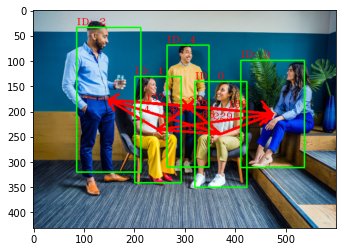

In [70]:
import cv2
import datetime
import imutils
import numpy as np
from centroidtracker import CentroidTracker
from itertools import combinations
import math
import matplotlib.pyplot as plt

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)
# detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
# detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

tracker = CentroidTracker(maxDisappeared=40, maxDistance=50)


def non_max_suppression_fast(boxes, overlapThresh):
    try:
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                                                   np.where(overlap > overlapThresh)[0])))

        return boxes[pick].astype("int")
    except Exception as e:
        print("Exception occurred in non_max_suppression : {}".format(e))


def main():
    #cap = cv2.VideoCapture('')

    fps_start_time = datetime.datetime.now()
    fps = 0
    total_frames = 0

    
    #ret, frame = cap.read()
    frame = cv2.imread('img/people.jpg')
    frame =  cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame = imutils.resize(frame, width=600)
    total_frames = total_frames + 1

    (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)

    detector.setInput(blob)
    person_detections = detector.forward()
    rects = []
    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])

            if CLASSES[idx] != "person":
                continue

            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            rects.append(person_box)

    boundingboxes = np.array(rects)
    boundingboxes = boundingboxes.astype(int)
    rects = non_max_suppression_fast(boundingboxes, 0.3)
    centroid_dict = dict()
    objects = tracker.update(rects)
    for (objectId, bbox) in objects.items():
        x1, y1, x2, y2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)
        cX = int((x1 + x2) / 2.0)
        cY = int((y1 + y2) / 2.0)


        centroid_dict[objectId] = (cX, cY, x1, y1, x2, y2)

        text = "ID: {}".format(objectId)
        cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)

    
    for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2):
        dx, dy = p1[0] - p2[0], p1[1] - p2[1]
        #shape = [(p1[0], p1[1]), (p2[0], p2[1])]
        #frame.line(shape, fill ="red", width = 0)
        distance = math.sqrt(dx * dx + dy * dy)
        shape = ((p1[0], p1[1]), (p2[0], p2[1]))
        print(shape)
        frame = cv2.arrowedLine(frame, (p1[0], p1[1]),(p2[0], p2[1]), (255,0,0), 3)
        text = str(round(distance))
        cv2.putText(frame, text, (round((p1[0]+p2[0]-10)/2), round((p1[1]+p2[1])/2-5)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)
        #frame.line(shape, fill ="red", width = 0)
        print(dx)
        print(dy)
        print("Distance:- ",distance)
        
    for id, box in centroid_dict.items():
        
        cv2.rectangle(frame, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2)
        
        

    fps_end_time = datetime.datetime.now()
    time_diff = fps_end_time - fps_start_time
    if time_diff.seconds == 0:
        fps = 0.0
    else:
        fps = (total_frames / time_diff.seconds)

    fps_text = "FPS: {:.2f}".format(fps)

    #cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)

    cv2.imshow("Application", frame)
    plt.imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


main()
